In [1]:
import pandas as pd
df= pd.read_csv('/content/sample_data/eCommerce_purchase.csv')

### **데이터 전처리**

---


1. 중복값 처리



In [3]:
df = df.drop_duplicates()



```
# This is formatted as code
```

2. 결측값 처리

In [4]:
df.describe()
df = df.dropna(subset = ['user_id','price','brand','category_code'])

#결측값 처리 확인
df.isna().sum()

,0
event_time,0
order_id,0
product_id,0
category_id,0
category_code,0
brand,0
price,0
user_id,0


- RFM 관점으로 분석할 것이기 때문에 결측치를 대체하는 것은 분석의 목적을 퇴색시키고 부정확한 결과를 가져올 수 있다고 생각
- 2000000개라는 충분한 데이터, 결측치를 제거한 이후에도 분석하기에 충분한 데이터를 확보할 수 있다는 근거를 가지고 결측치 제거

3. 이상치(Outliers) 처리

In [5]:
#문자형식에서 날짜형식으로 변환
df['event_time'] = pd.to_datetime(df['event_time'])

set_of_year_month = list(set([(x.year, x.month) for x in df['event_time']])) ## 송장날짜에서 연도와 월정보를 가져온다.
for ym in sorted(set_of_year_month, key=lambda x: (x[0], x[1])): ## 연도와 월정보를 연도, 월 순으로 출력
    print(f'{ym[0]}년 {ym[1]}월')

1970년 1월
2020년 1월
2020년 4월
2020년 5월
2020년 6월
2020년 7월


- 날짜에서 1970년이라는 이상치를 발견 -> 제거

In [6]:
df = df[df['event_time'].dt.year != 1970]
print(df['event_time'].describe())

count                                  33910
mean     2020-05-10 06:59:28.546476032+00:00
min                2020-01-05 04:06:18+00:00
25%         2020-05-06 13:29:22.500000+00:00
50%                2020-05-23 16:59:17+00:00
75%                2020-06-19 06:33:16+00:00
max                2020-07-08 13:44:09+00:00
Name: event_time, dtype: object


In [7]:
df.head()

,event_time,order_id,product_id,category_id,category_code,brand,price,user_id
0,2020-04-24 11:50:39+00:00,2294359932054536986,1515966223509089906,2.268105e+18,electronics.tablet,samsung,162.01,1.515916e+18
2,2020-04-24 14:37:43+00:00,2294444024058086220,2273948319057183658,2.268105e+18,electronics.audio.headphone,huawei,77.52,1.515916e+18
5,2020-04-26 08:45:57+00:00,2295716521449619559,1515966223509261697,2.268105e+18,furniture.kitchen.table,maestro,39.33,1.515916e+18
6,2020-04-26 09:33:47+00:00,2295740594749702229,1515966223509104892,2.268105e+18,electronics.smartphone,apple,1387.01,1.515916e+18
10,2020-04-26 14:55:26+00:00,2295902490203259134,2273948311742316796,2.268105e+18,appliances.kitchen.refrigerators,lg,462.94,1.515916e+18


- Category_code는 기기 카테고리.세부제품 형식으로 입력되어 있는 것을 확인

In [8]:
#기기 카테고리
df['category'] = df['category_code'].str.split('.').str[0]

#제품
df['product']=df['category_code'].str.split('.').str[-1]

df.head()

<ipython-input-8-77a826b57bd9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['category'] = df['category_code'].str.split('.').str[0]


,event_time,order_id,product_id,category_id,category_code,brand,price,user_id,category,product
0,2020-04-24 11:50:39+00:00,2294359932054536986,1515966223509089906,2.268105e+18,electronics.tablet,samsung,162.01,1.515916e+18,electronics,tablet
2,2020-04-24 14:37:43+00:00,2294444024058086220,2273948319057183658,2.268105e+18,electronics.audio.headphone,huawei,77.52,1.515916e+18,electronics,headphone
5,2020-04-26 08:45:57+00:00,2295716521449619559,1515966223509261697,2.268105e+18,furniture.kitchen.table,maestro,39.33,1.515916e+18,furniture,table
6,2020-04-26 09:33:47+00:00,2295740594749702229,1515966223509104892,2.268105e+18,electronics.smartphone,apple,1387.01,1.515916e+18,electronics,smartphone
10,2020-04-26 14:55:26+00:00,2295902490203259134,2273948311742316796,2.268105e+18,appliances.kitchen.refrigerators,lg,462.94,1.515916e+18,appliances,refrigerators


- 제한된 데이터의 확보와 세부적인 분석을 위해 해당 데이터를 카테고리, 제품으로 나누어 저장

### **RFM 세분화 분석**

---



1. 3분할을 통해 R, F, M 점수 부여

In [9]:
today = pd.to_datetime('2020-11-22')

* '2020-11-21'가 데이터 상 가장 최근 날짜임으로 '2020-11-22'을 오늘 날짜라고 가정하고 분석을 진행

In [10]:
import pandas as pd

# RFM 계산
RFM_df = df.loc[:,['user_id', 'order_id', 'event_time', 'price']]

# Time Zone 지우기
RFM_df['event_time'] = RFM_df['event_time'].apply(lambda x : x.replace(tzinfo = None))

rfm = RFM_df.groupby('user_id').agg({
    'event_time': lambda x: (today - x.max()).days,  # Recency
    'order_id': 'count',  # Frequency
    'price': 'sum'  # Monetary
})

# 컬럼 이름 변경
rfm.columns = ['recency', 'frequency', 'monetary']

# RFM 점수 계산 (3분위수 사용)
r_labels = range(3, 0, -1)  # Recency 레이블
f_labels = range(1, 4)      # Frequency 레이블
m_labels = range(1, 4)      # Monetary 레이블

# Recency 점수 계산 (기존 방식 유지)
r_quartiles = pd.qcut(rfm['recency'], q=3, labels=False)

# Frequency 점수 계산 (누적 분포 함수 사용)
f_rank = rfm['frequency'].rank(method='dense', pct=True)
f_quartiles = pd.cut(f_rank, bins=[0, 1/3, 2/3, 1], labels=False)

# Monetary 점수 계산 (기존 방식 유지)
m_quartiles = pd.qcut(rfm['monetary'], q=3, labels=False)

# 레이블 할당
rfm['R'] = r_quartiles.map(lambda x: r_labels[x] if pd.notnull(x) else 0)
rfm['F'] = f_quartiles.map(lambda x: f_labels[x] if pd.notnull(x) else 0)
rfm['M'] = m_quartiles.map(lambda x: m_labels[x] if pd.notnull(x) else 0)

# RFM_Score 계산
rfm['RFM_Score'] = rfm['R'].astype(str) + rfm['F'].astype(str) + rfm['M'].astype(str)

# 결과 출력
print(rfm.head())

              recency  frequency  monetary  R  F  M RFM_Score
user_id                                                      
1.515916e+18      189          1     43.96  1  1  1       111
1.515916e+18      185          1    856.23  2  1  3       213
1.515916e+18      165          7    326.23  2  1  3       213
1.515916e+18      195          1     13.87  1  1  1       111
1.515916e+18      150          5    175.67  3  1  2       312


- F의 경우 특정 범위에 동일한 값이 몰려있어 단순 qcut으로 3분할이 불가
- Dense Rnak를 사용하여 frequency 값의 백분위 순위를 계산하여 동일하게 3분할

In [12]:
rfm_grouped = rfm.groupby(['R', 'F', 'M']).size().reset_index(name='count')
print(rfm_grouped)

    R  F  M  count
0   1  1  1   2312
1   1  1  2   1973
2   1  1  3   1536
3   1  2  3     25
4   1  3  3     32
5   2  1  1   1775
6   2  1  2   2002
7   2  1  3   2219
8   2  2  3      5
9   3  1  1   1923
10  3  1  2   2036
11  3  1  3   2144
12  3  2  3     11
13  3  3  3      2


- RFM 점수 분포 현황 확인

2. 고객 유형 분류

In [13]:
#고객 세그먼트 별 분할
def segment_customers(row):
    if row['RFM_Score'] in ['333','323']:
        return 'VIP Customer'
    elif row['RFM_Score'] in ['313', '223']:
        return 'Loyal Customers'
    elif row['RFM_Score'] in ['213', '123', '113']:
        return 'High-Value Customers'
    elif row['RFM_Score'] in ['312', '311']:
        return 'Prospective Customers'
    elif row['RFM_Score'] in ['211', '212']:
        return 'Risk Customers'
    else:
        return 'Churned Customers'

rfm['Customer_Segment'] = rfm.apply(segment_customers, axis=1)

In [14]:
segment_percentages = (rfm['Customer_Segment'].value_counts() / rfm['Customer_Segment'].count()) * 100
formatted_percentages = segment_percentages.round(2).astype(str) + '%'
print(formatted_percentages)

Customer_Segment
Churned Customers        23.99%
Prospective Customers     22.0%
High-Value Customers     21.01%
Risk Customers           20.99%
Loyal Customers          11.94%
VIP Customer              0.07%
Name: count, dtype: object


- 고객 세그먼트 비율 확인

3. ANOVA test 진행

각 세그먼트에 대한 R, F, M 값의 평균 값 차이에 대한 통계적 유의성 검증

ANOVA TEST를 진행하기 위한 기본 가정 검증

독립성 검증

In [15]:
from scipy.stats import chi2_contingency

# recency를 범주화
rfm['recency_cat'] = pd.cut(rfm['recency'], bins=3)

# 카이제곱 검정 수행
contingency_table = pd.crosstab(rfm['Customer_Segment'], rfm['recency_cat'])
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-square statistic: {chi2}")
print(f"p-value: {p_value}")

Chi-square statistic: 5819.71506724454
p-value: 0.0


In [16]:
# frequency를 범주화
rfm['frequency_cat'] = pd.cut(rfm['frequency'], bins=3)

# 카이제곱 검정 수행
contingency_table = pd.crosstab(rfm['Customer_Segment'], rfm['frequency_cat'])
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-square statistic: {chi2}")
print(f"p-value: {p_value}")

Chi-square statistic: 680.5692505967423
p-value: 9.301287522437782e-140


In [17]:
# monetary를 범주화
rfm['monetary_cat'] = pd.cut(rfm['monetary'], bins=3)

# 카이제곱 검정 수행
contingency_table = pd.crosstab(rfm['Customer_Segment'], rfm['monetary_cat'])
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-square statistic: {chi2}")
print(f"p-value: {p_value}")

Chi-square statistic: 1496.4403153606097
p-value: 0.0


- 카이제곱 통계량을 통해 관측값과 기대 값의 차이가 크다는 것을 확인

-> recency와 고객 세그먼트 두 변수가 연관성이 있다는것을 뜻함

- 귀무가설(H0): 두 변수는 서로 독립이다.
- 대립가설(H1): 두 변수는 서로 독립적이지 않다.


-> P-value가 0.05 보다 작음으로 귀무가설을 기각하고 대립가설을 채택

분산성 검증

In [18]:
from scipy.stats import levene

# 각 세그먼트별로 recency 값 추출
segments = rfm['Customer_Segment'].unique()
recency_groups = [rfm[rfm['Customer_Segment'] == seg]['recency'] for seg in segments]

# Levene's 검정 수행
statistic, p_value = levene(*recency_groups)

print(f"Levene's test statistic: {statistic}")
print(f"p-value: {p_value}")

Levene's test statistic: 209.81916288647773
p-value: 3.217077746329545e-218


In [19]:
# 각 세그먼트별로 frequency 값 추출
segments = rfm['Customer_Segment'].unique()
frequency_groups = [rfm[rfm['Customer_Segment'] == seg]['frequency'] for seg in segments]

# Levene's 검정 수행
statistic, p_value = levene(*frequency_groups)

print(f"Levene's test statistic: {statistic}")
print(f"p-value: {p_value}")

Levene's test statistic: 78.18556837907762
p-value: 2.1023605055004796e-81


In [20]:
# 각 세그먼트별로 monetary 값 추출
segments = rfm['Customer_Segment'].unique()
monetary_groups = [rfm[rfm['Customer_Segment'] == seg]['monetary'] for seg in segments]

# Levene's 검정 수행
statistic, p_value = levene(*monetary_groups)

print(f"Levene's test statistic: {statistic}")
print(f"p-value: {p_value}")

Levene's test statistic: 249.07788989269756
p-value: 3.4893743846944056e-258


- Levenes 통계량을 통해 그룹 간 분산의 차이가 크다는 것을 확인

- 귀무가설(H0): 각 그룹(고객 세그먼트)의 분산은 동일하다.
- 대립가설(H1): 각 그룹의 분산은 동일하지 않다.


-> P-value가 0.05 보다 작음으로 귀무가설을 기각하고 대립가설을 채택

In [21]:
from scipy.stats import kstest

# recency 정규분포와 비교
result = kstest(rfm['recency'], 'norm', args=(rfm['recency'].mean(), rfm['recency'].std()))
print(f"K-S test statistic: {result.statistic}")
print(f"p-value: {result.pvalue}")

K-S test statistic: 0.1595598669016719
p-value: 0.0


In [22]:
# frequency 정규분포와 비교
result = kstest(rfm['frequency'], 'norm', args=(rfm['frequency'].mean(), rfm['frequency'].std()))
print(f"K-S test statistic: {result.statistic}")
print(f"p-value: {result.pvalue}")

K-S test statistic: 0.42697761943459583
p-value: 0.0


In [23]:
# monetary 정규분포와 비교
result = kstest(rfm['monetary'], 'norm', args=(rfm['monetary'].mean(), rfm['monetary'].std()))
print(f"K-S test statistic: {result.statistic}")
print(f"p-value: {result.pvalue}")

K-S test statistic: 0.3523933194627317
p-value: 0.0


- 귀무가설(H0): 데이터는 정규분포를 따른다.
- 대립가설(H1): 데이터는 정규분포를 따르지 않는다.

-> P-value가 0.05 보다 작음으로 귀무가설을 기각하고 대립가설을 채택

>즉, 데이터가 정규분포를 따르지 않는다는 것을 의미

---



정규성이 만족하지 못함으로 ANOVA TEST를 위한 기본 가정을 만족시키지 못함

-> Kruskal-Wallis H-test(비모수적 검정)를 사용하여 중앙값 차이를 비교

In [24]:
from scipy.stats import kruskal

group1 = rfm[rfm['Customer_Segment'] == 'Loyal Customers']['recency']
group2 = rfm[rfm['Customer_Segment'] == 'High-Value Customers']['recency']
group3 = rfm[rfm['Customer_Segment'] == 'Prospective Customers']['recency']
group4 = rfm[rfm['Customer_Segment'] == 'Risk Customers']['recency']
group5 = rfm[rfm['Customer_Segment'] == 'Churned Customers']['recency']


statistic, p_value = kruskal(group1, group2, group3, group4, group5)

print(f"Kruskal-Wallis test statistic: {statistic}")
print(f"p-value: {p_value}")

Kruskal-Wallis test statistic: 14893.292055259944
p-value: 0.0


In [25]:
group6 = rfm[rfm['Customer_Segment'] == 'Loyal Customers']['frequency']
group7 = rfm[rfm['Customer_Segment'] == 'High-Value Customers']['frequency']
group8 = rfm[rfm['Customer_Segment'] == 'Prospective Customers']['frequency']
group9 = rfm[rfm['Customer_Segment'] == 'Risk Customers']['frequency']
group10 = rfm[rfm['Customer_Segment'] == 'Churned Customers']['frequency']


statistic, p_value = kruskal(group6, group7, group8, group9, group10)

print(f"Kruskal-Wallis test statistic: {statistic}")
print(f"p-value: {p_value}")

Kruskal-Wallis test statistic: 2167.602949034542
p-value: 0.0


In [26]:
group11 = rfm[rfm['Customer_Segment'] == 'Loyal Customers']['monetary']
group12 = rfm[rfm['Customer_Segment'] == 'High-Value Customers']['monetary']
group13 = rfm[rfm['Customer_Segment'] == 'Prospective Customers']['monetary']
group14 = rfm[rfm['Customer_Segment'] == 'Risk Customers']['monetary']
group15 = rfm[rfm['Customer_Segment'] == 'Churned Customers']['monetary']


statistic, p_value = kruskal(group11, group12, group13, group14, group15)

print(f"Kruskal-Wallis test statistic: {statistic}")
print(f"p-value: {p_value}")

Kruskal-Wallis test statistic: 11829.887212529426
p-value: 0.0


Kruskal-Wallis 통계량은 그룹 간의 중앙값 차이를 나타내며, 값이 클수록 그룹 간 차이가 크다는 것을 의미

- 귀무가설(H0): 모든 그룹의 중앙값은 동일하다.
- 대립가설(H1): 적어도 하나의 그룹의 중앙값이 다르다.

-> P-value가 0.05 보다 작음으로 귀무가설을 기각하고 대립가설을 채택

>따라서, 고객 세그먼트 간에 'recency', 'frequency', 'monetary'의 중앙값이 유의미한 차이가 있다는 것을 확인

사후검정

> 데이터가 정규분포를 따르지 않아 Kruskal-Wallis(비모수 검정)을 사용한 경우,

> 집단간의 차이에 대한 유의성을 확인하기 위해 Mann-Whitney U 검정을 사용

> 하지만, 3집단 이상을 비교하다 2집단을 비교하게 되면, 유의수준이 0.05를 유지하기 힘듬

> 이에 Mann-Whitney U 검정을 통해 차이를 비교하고, Bonferroni 교정을 통해 alpha값을 보정하여 유의성을 확인

In [39]:
from scipy.stats import mannwhitneyu
from itertools import combinations

groups = [group1, group2, group3, group4, group5]
group_names = ['Loyal', 'High-Value', 'Prospective', 'Risk', 'Churned']

# 모든 가능한 그룹 쌍에 대해 Mann-Whitney U 검정 수행
num_comparisons = len(list(combinations(groups, 2)))
alpha = 0.05  # 유의수준
bonferroni_alpha = alpha / num_comparisons

results = []

for (g1, n1), (g2, n2) in combinations(zip(groups, group_names), 2):
    statistic, p_value = mannwhitneyu(g1, g2)
    results.append((n1, n2, p_value))

# Bonferroni 교정 적용 및 결과 출력
print("Recency값에 대한 Bonferroni 사후 검정 결과:")
print("그룹1 vs 그룹2: 조정된 p-값 (유의성)")
for n1, n2, p in results:
    adjusted_p = min(p * num_comparisons, 1)  # Bonferroni 교정
    significance = "유의함" if adjusted_p < alpha else "유의하지 않음"
    print(f"{n1} vs {n2}: {adjusted_p:.4f} ({significance})")

Recency값에 대한 Bonferroni 사후 검정 결과:
그룹1 vs 그룹2: 조정된 p-값 (유의성)
Loyal vs High-Value: 0.0000 (유의함)
Loyal vs Prospective: 1.0000 (유의하지 않음)
Loyal vs Risk: 0.0000 (유의함)
Loyal vs Churned: 0.0000 (유의함)
High-Value vs Prospective: 0.0000 (유의함)
High-Value vs Risk: 0.0000 (유의함)
High-Value vs Churned: 0.0000 (유의함)
Prospective vs Risk: 0.0000 (유의함)
Prospective vs Churned: 0.0000 (유의함)
Risk vs Churned: 0.0000 (유의함)


In [40]:
groups = [group6, group7, group8, group9, group10]

# 모든 가능한 그룹 쌍에 대해 Mann-Whitney U 검정 수행
num_comparisons = len(list(combinations(groups, 2)))
alpha = 0.05  # 유의수준
bonferroni_alpha = alpha / num_comparisons

results = []

for (g1, n1), (g2, n2) in combinations(zip(groups, group_names), 2):
    statistic, p_value = mannwhitneyu(g1, g2)
    results.append((n1, n2, p_value))

# Bonferroni 교정 적용 및 결과 출력
print("Frequency값에 대한 Bonferroni 사후 검정 결과:")
print("그룹1 vs 그룹2: 조정된 p-값 (유의성)")
for n1, n2, p in results:
    adjusted_p = min(p * num_comparisons, 1)  # Bonferroni 교정
    significance = "유의함" if adjusted_p < alpha else "유의하지 않음"
    print(f"{n1} vs {n2}: {adjusted_p:.4f} ({significance})")

Frequency값에 대한 Bonferroni 사후 검정 결과:
그룹1 vs 그룹2: 조정된 p-값 (유의성)
Loyal vs High-Value: 0.0000 (유의함)
Loyal vs Prospective: 0.0000 (유의함)
Loyal vs Risk: 0.0000 (유의함)
Loyal vs Churned: 0.0000 (유의함)
High-Value vs Prospective: 0.0000 (유의함)
High-Value vs Risk: 0.0000 (유의함)
High-Value vs Churned: 0.0000 (유의함)
Prospective vs Risk: 0.1316 (유의하지 않음)
Prospective vs Churned: 0.0000 (유의함)
Risk vs Churned: 0.0000 (유의함)


In [41]:
groups = [group11, group12, group13, group14, group15]

# 모든 가능한 그룹 쌍에 대해 Mann-Whitney U 검정 수행
num_comparisons = len(list(combinations(groups, 2)))
alpha = 0.05  # 유의수준
bonferroni_alpha = alpha / num_comparisons

results = []

for (g1, n1), (g2, n2) in combinations(zip(groups, group_names), 2):
    statistic, p_value = mannwhitneyu(g1, g2)
    results.append((n1, n2, p_value))

# Bonferroni 교정 적용 및 결과 출력
print("Monetary값에 대한 Bonferroni 사후 검정 결과:")
print("그룹1 vs 그룹2: 조정된 p-값 (유의성)")
for n1, n2, p in results:
    adjusted_p = min(p * num_comparisons, 1)  # Bonferroni 교정
    significance = "유의함" if adjusted_p < alpha else "유의하지 않음"
    print(f"{n1} vs {n2}: {adjusted_p:.4f} ({significance})")

Monetary값에 대한 Bonferroni 사후 검정 결과:
그룹1 vs 그룹2: 조정된 p-값 (유의성)
Loyal vs High-Value: 0.0000 (유의함)
Loyal vs Prospective: 0.0000 (유의함)
Loyal vs Risk: 0.0000 (유의함)
Loyal vs Churned: 0.0000 (유의함)
High-Value vs Prospective: 0.0000 (유의함)
High-Value vs Risk: 0.0000 (유의함)
High-Value vs Churned: 0.0000 (유의함)
Prospective vs Risk: 1.0000 (유의하지 않음)
Prospective vs Churned: 0.0000 (유의함)
Risk vs Churned: 0.0000 (유의함)


> 사후 검정 결과를 통해,
- Recency값에 대해 Loyal과 Prospective 고객들의 차이가 유의하지 않다는 것을 확인
- Frequency값에 대해 Prospective와 Risk 고객들의 차이가 유의하지 않다는 것을 확인
- Monetary값에 대해 Prospective와 Risk 고객들의 차이가 유의하지 않다는 것을 확인

> 종합적으로, Recency값을 제외하고 타겟 고객 집단으로 생각하고 있는 VIP, Loyal, High-Value 고객과 이외의 집단간의 차이가 유의하다는 결과를 확인

4. RFM 관점 EDA

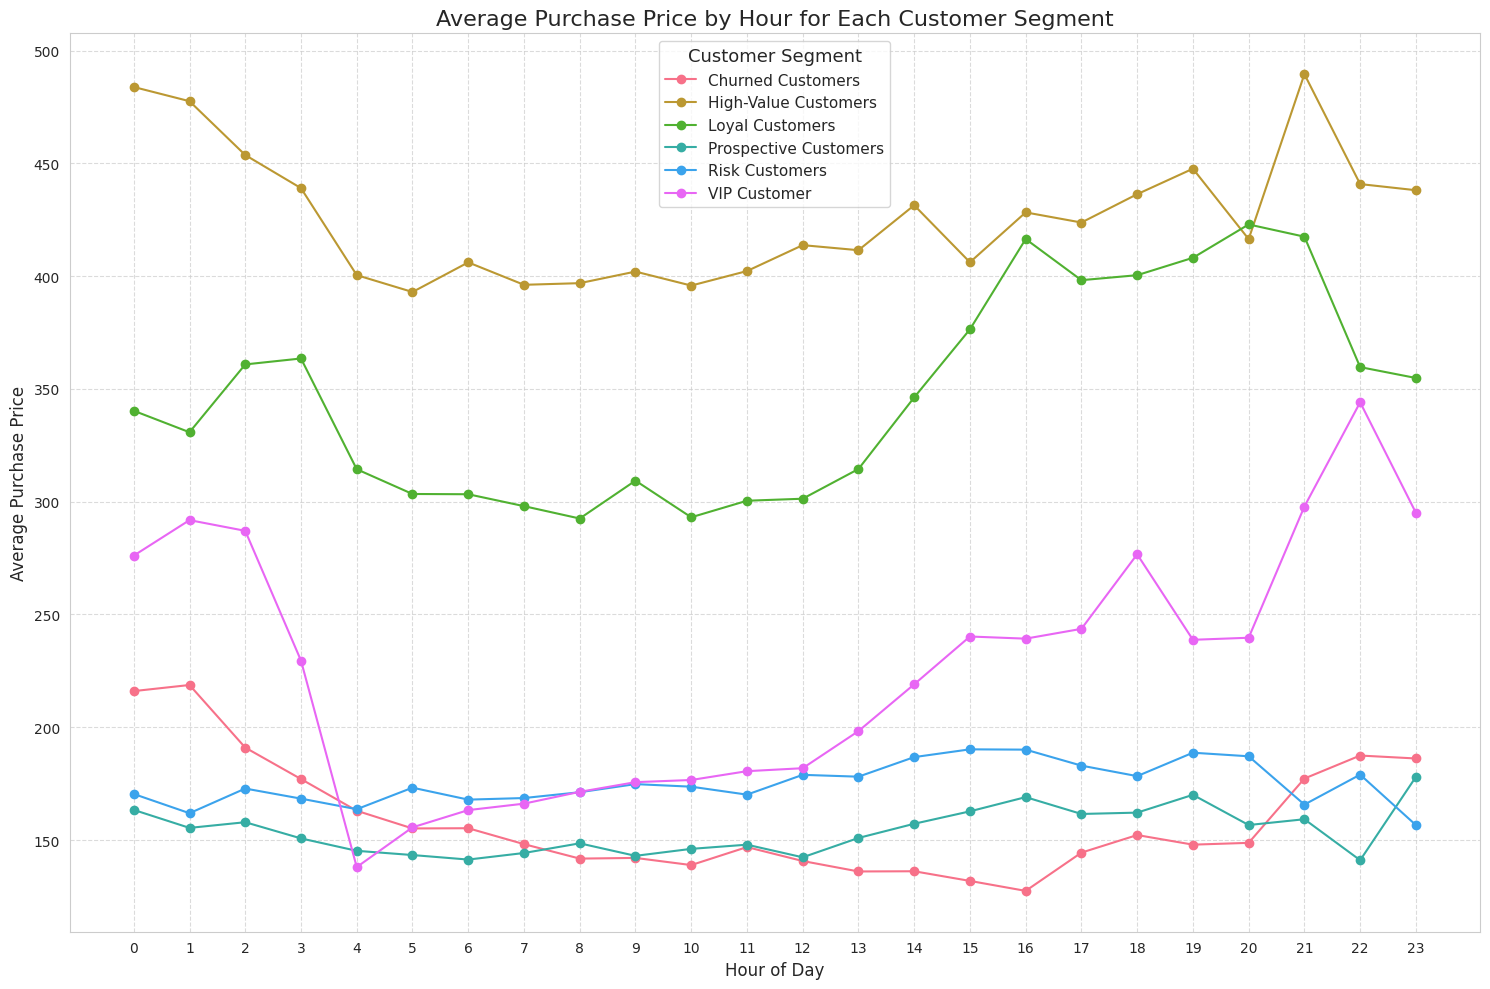

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# 원본 데이터에 세그먼트 정보 추가
df = df.merge(rfm[['Customer_Segment']], left_on='user_id', right_index=True)

df['event_time'] = pd.to_datetime(df['event_time'])
df['hour'] = df['event_time'].dt.hour

# 시간대별, 세그먼트별 평균 구매 가격 계산
hourly_avg_price = df.groupby(['Customer_Segment', 'hour'])['price'].mean().unstack()

# 그래프 설정
plt.figure(figsize=(15, 10))
sns.set_style("whitegrid")
sns.set_palette("husl")

# 각 세그먼트별로 선 그래프 그리기
for segment in hourly_avg_price.index:
    plt.plot(hourly_avg_price.columns, hourly_avg_price.loc[segment], label=segment, marker='o')

plt.title('Average Purchase Price by Hour for Each Customer Segment', fontsize=16)
plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Average Purchase Price', fontsize=12)
plt.legend(title='Customer Segment', title_fontsize='13', fontsize='11', loc='best')
plt.xticks(range(0, 24))
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

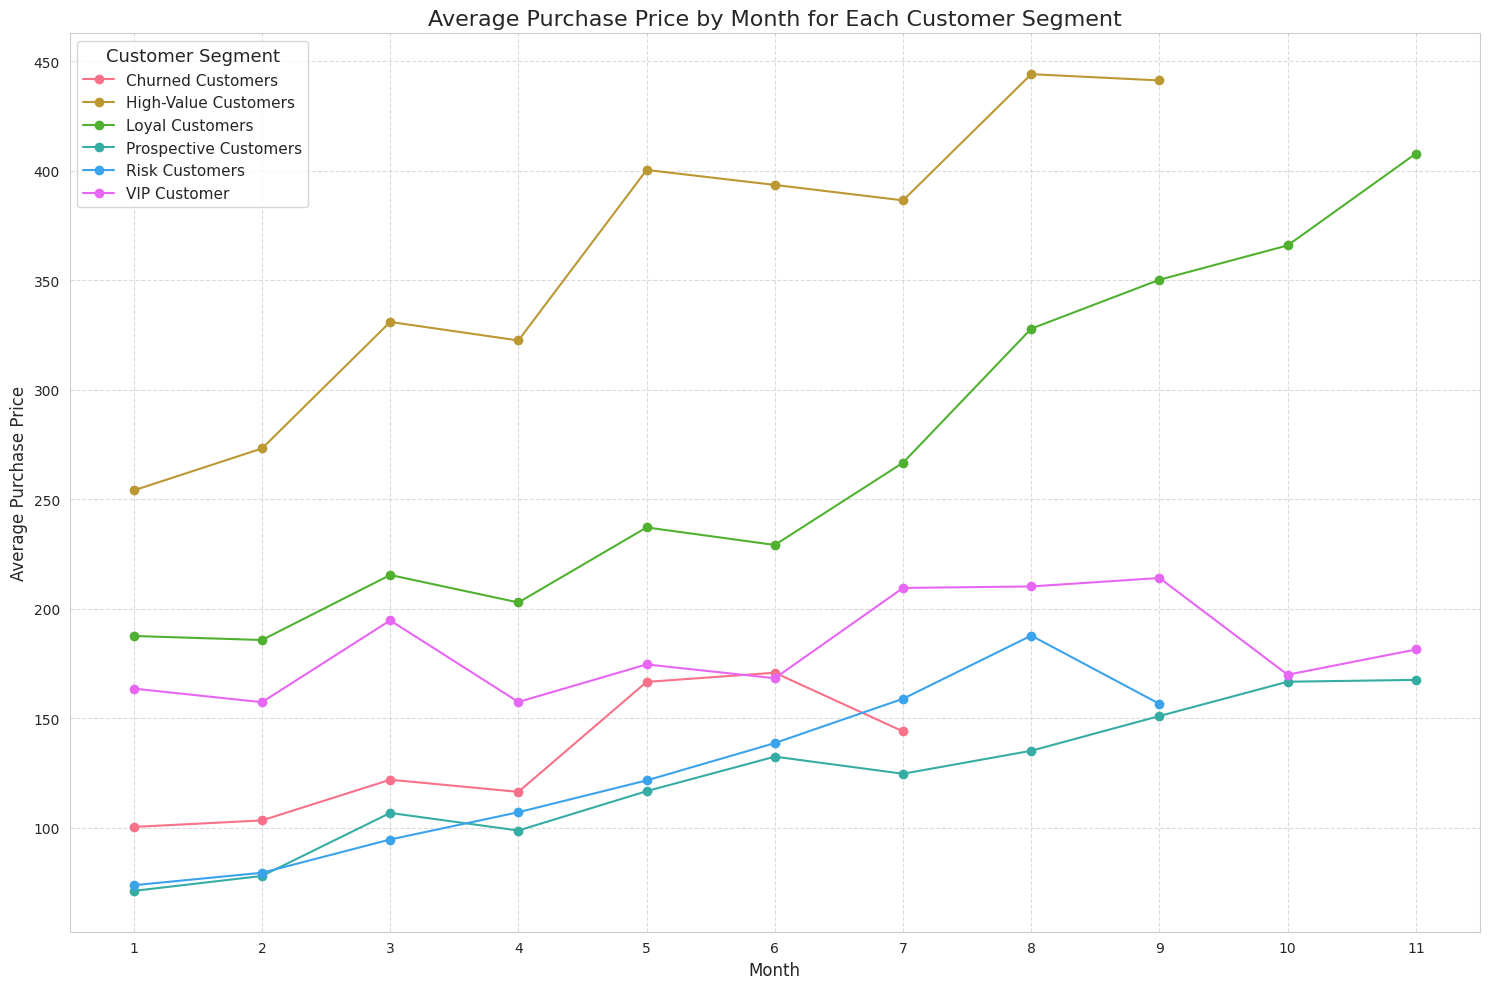

In [ ]:
df['month'] = df['event_time'].dt.month

# 월별별, 세그먼트별 평균 구매 가격 계산
monthly_avg_price = df.groupby(['Customer_Segment', 'month'])['price'].mean().unstack()

# 그래프 설정
plt.figure(figsize=(15, 10))
sns.set_style("whitegrid")
sns.set_palette("husl")

# 각 세그먼트별로 선 그래프 그리기
for segment in monthly_avg_price.index:
    plt.plot(monthly_avg_price.columns, monthly_avg_price.loc[segment], label=segment, marker='o')

plt.title('Average Purchase Price by Month for Each Customer Segment', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Average Purchase Price', fontsize=12)
plt.legend(title='Customer Segment', title_fontsize='13', fontsize='11', loc='best')
plt.xticks(range(1, 12))
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

- 시간, 월별 평균 구매 가격을 확인한 결과, 높은가치고객/ 충성고객/ VIP 고객의 액수가 높은 것을 파악
- 특히, 높은가치고객의 구매 액수가 압도적으로 높아보임.
- 하지만, 9월 이후 구매가 없는 것을 확인해 볼 필요가 있음.
- 충성 고객의 구매가 꾸준히 늘어나고 있는 것이 인상적.

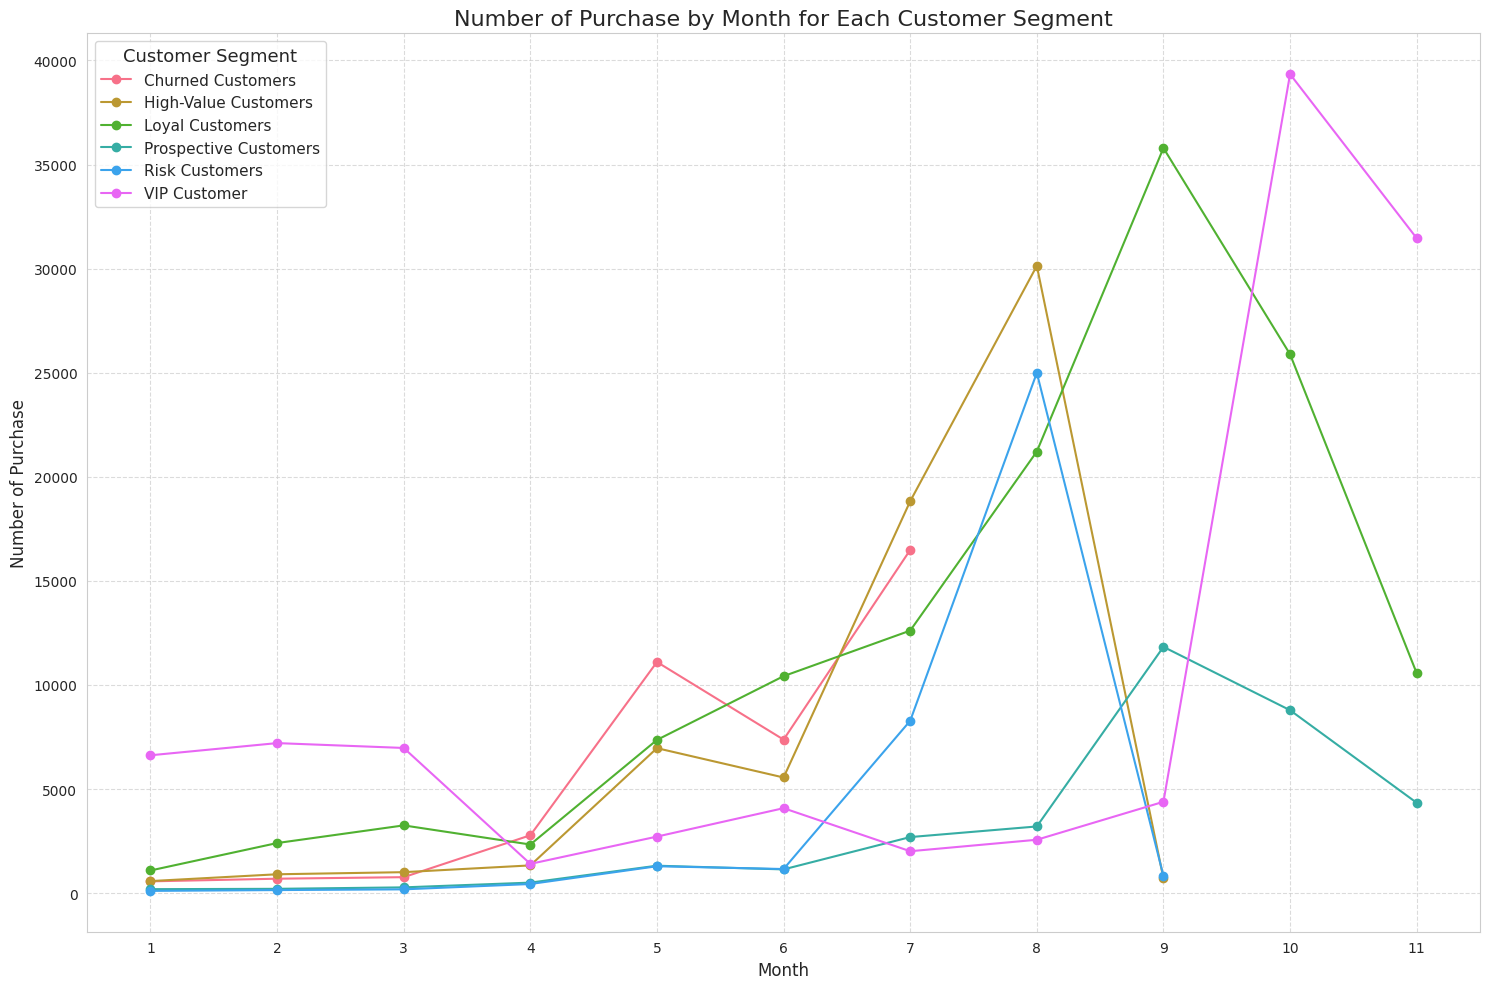

In [ ]:
df['month'] = df['event_time'].dt.month

# 월별별, 세그먼트별 평균 구매 가격 계산
monthly_numberoforder = df.groupby(['Customer_Segment', 'month'])['order_id'].count().unstack()

# 그래프 설정
plt.figure(figsize=(15, 10))
sns.set_style("whitegrid")
sns.set_palette("husl")

# 각 세그먼트별로 선 그래프 그리기
for segment in monthly_numberoforder.index:
    plt.plot(monthly_numberoforder.columns, monthly_numberoforder.loc[segment], label=segment, marker='o')

plt.title('Number of Purchase by Month for Each Customer Segment', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Number of Purchase', fontsize=12)
plt.legend(title='Customer Segment', title_fontsize='13', fontsize='11', loc='best')
plt.xticks(range(1, 12))
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

- 연말에 가까울수록 고객들의 구매 빈도가 늘어나는것을 확인

-> 연말 시즌에 Thanks giving, Black Friday와 같은 특별 할인 행사를 진행하는 것에 대한 시즈널리티가 반영된 것으로 파악
- VIP 고객의 경우, 10월부터 극격히 구매가 늘어나는 추세

        Customer_Segment       price
1   High-Value Customers  410.543027
2        Loyal Customers  320.410565
5           VIP Customer  176.969743
4         Risk Customers  174.746277
0      Churned Customers  151.618906
3  Prospective Customers  149.660619


<ipython-input-585-08eb72fcb1e3>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Customer_Segment', y='price', data=segment_avg_sorted, palette='viridis')


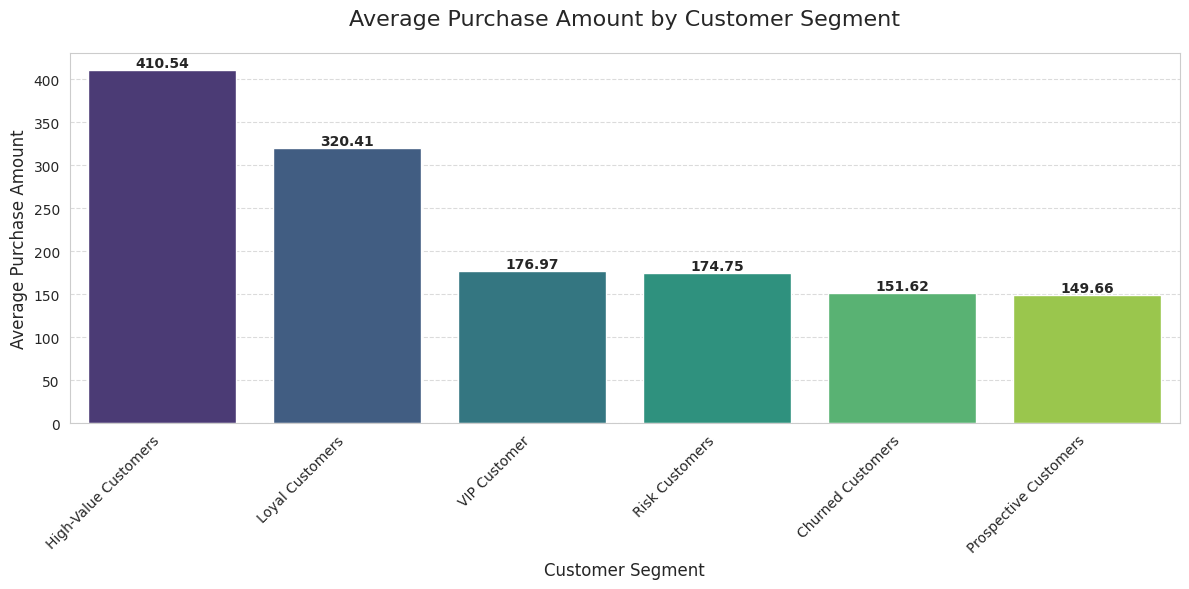

In [ ]:
#세그먼트별 평균 구매액
segment_avg = df.groupby('Customer_Segment')['price'].mean().reset_index()
segment_avg_sorted = segment_avg.sort_values(by='price', ascending=False)
print(segment_avg_sorted)

plt.figure(figsize=(12, 6))
ax = sns.barplot(x='Customer_Segment', y='price', data=segment_avg_sorted, palette='viridis')

# 그래프 제목 및 레이블 설정
plt.title('Average Purchase Amount by Customer Segment', fontsize=16, pad=20)
plt.xlabel('Customer Segment', fontsize=12)
plt.ylabel('Average Purchase Amount', fontsize=12)

# x축 레이블 회전
plt.xticks(rotation=45, ha='right')

# y축 눈금 포맷 설정 (천 단위 구분기호 추가)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))

# 막대 위에 값 표시
for i, v in enumerate(segment_avg_sorted['price']):
    ax.text(i, v, f'{v:,.2f}', ha='center', va='bottom', fontweight='bold')

# 그리드 추가
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 레이아웃 조정
plt.tight_layout()

# 그래프 표시
plt.show()

- 높은 가치 고객 - 충성 고객 - VIP 고객 순으로 평균 금액이 높다는 것을 확인 할 수 있음
- 상위 3개 그룹(High-Value, Loyal, VIP)이 차지하는 구매 비중이 높다는 점을 확인

Q. VIP 고객의 평균 금액이 가장 높지 않은 이유는 qcut의 작동방식과 Monetary의 분포가 정규 분포를 따르지 않는데에 있음


- qcut은 구간으로 범위를 나누긴 하지만, 각 구간의 경계는 데이터의 분포에 따라 결정되므로, 최상위 구간(3)에 포함되는 데이터가 반드시 높은 값을 가지는 것은 아님
- 또한 데이터가 극단적으로 치우쳐져 있거나, 상위 1%의 극단적인 값들이 포함되어 있지 않은 경우, 상위 구간의 평균 금액이 기대보다 낮을 수 있음

=> EDA에 대해 종합적으로 고려해보았을때, 상위 그룹이 전체 매출의 많은 부분을 차지하는 것을 알 수 있음.

전자 기기를 파는 플랫폼 비즈니스에서 큰 매출을 만들어내는 고객들을 집중 관리 및 증가시키는 것이 소액을 자주 구매하는 고객 보다 중요하다고 판단.

이에 High-Value, Loyal Customers의 유저의 리텐션을 높여 재구매를 유도하는 것이 매출을 꾸준히 향상시킬 수 있을 것이라고 생각 (가설)

Loyal Customers와 High-Value Customers의 Drill-Down에 대한 필요성을 느낌

### **코호트 분석**

---



<전체 유저에 대해>

유저가 처음 가입한 날을 가입일로 기준삼고 코호트 분석을 진행

In [ ]:
Join_dates = df.groupby('user_id')['event_time'].min().reset_index()
Join_dates.columns = ['user_id', 'Join_Date']
df = pd.merge(df, Join_dates, on='user_id', how='left')

In [ ]:
# 주문 주기
df['cohort_month'] = df['Join_Date'].dt.to_period('M')
df['join_month'] = df['cohort_month'].dt.month

<ipython-input-36-f129b739eed7>:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['cohort_month'] = df['Join_Date'].dt.to_period('M')


1. 전체 유저 코호트 분석

<ipython-input-37-aa521129c73f>:6: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['cohort_month'] = df['Join_Date'].dt.to_period('M')


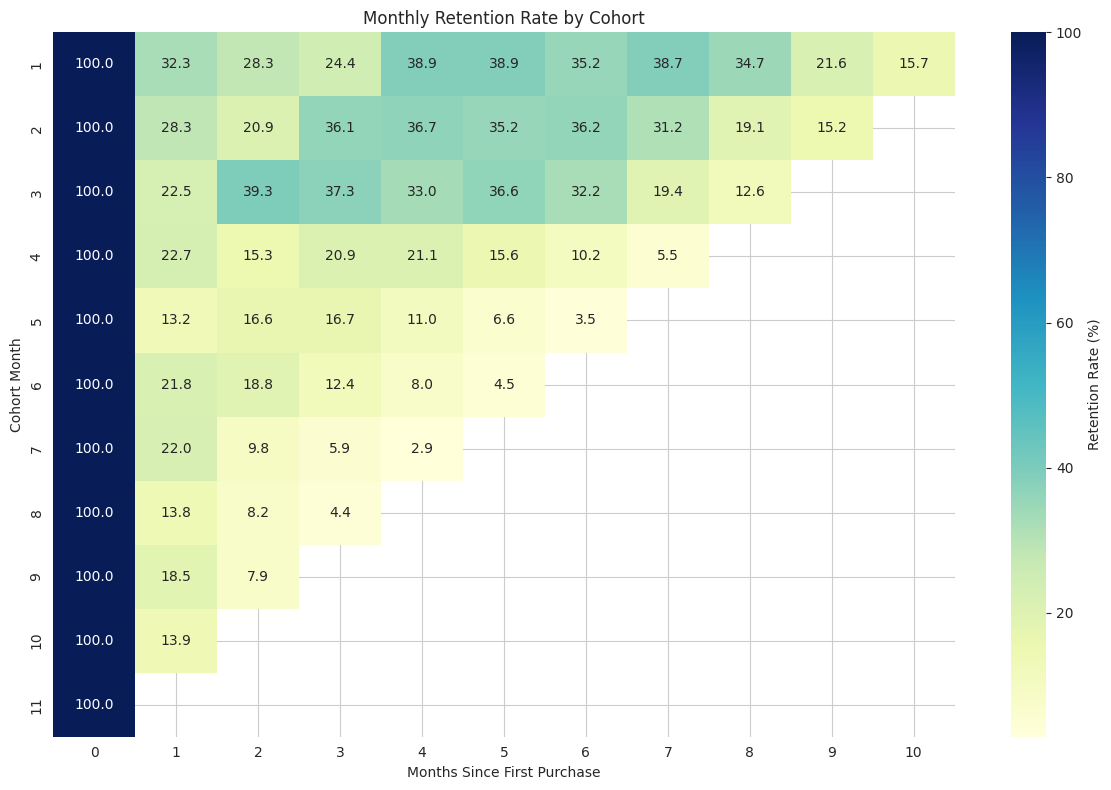


월별 리텐션 코호트 분석 결과:
    cohort_month  month_diff  Total_users  Cohort_Size  Retention_Rate
0              1           0         1431         1431      100.000000
1              1           1          462         1431       32.285115
2              1           2          405         1431       28.301887
3              1           3          349         1431       24.388539
4              1           4          557         1431       38.923829
..           ...         ...          ...          ...             ...
61             9           1         1580         8552       18.475210
62             9           2          675         8552        7.892891
63            10           0         5771         5771      100.000000
64            10           1          803         5771       13.914400
65            11           0         2959         2959      100.000000

[66 rows x 5 columns]


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 주문 주기
df['cohort_month'] = df['Join_Date'].dt.to_period('M')
df['order_month'] = pd.to_datetime(df['month'], format='%m').dt.to_period('M')

# 주문 주기
df['cohort_month'] = df['Join_Date'].dt.month
df['order_month'] = df['event_time'].dt.month

# 코호트 월과 주문 월 사이의 차이 계산
df['month_diff'] = df['order_month'] - df['cohort_month']


# 월별 구매자 수
monthly_cohort = df.groupby(['cohort_month', 'month_diff'])['user_id'].nunique().reset_index()
monthly_cohort = monthly_cohort.rename(columns={'user_id': 'Total_users'})

# 월별 코호트 전체 유저 (첫달 가입자수가 기준)
cohort_sizes = monthly_cohort[monthly_cohort['month_diff'] == 0].set_index('cohort_month')['Total_users']
cohort_sizes = cohort_sizes.rename('Cohort_Size')

# 월별 구매자수와 가입한 전체 인원 병합
monthly_cohort = monthly_cohort.set_index('cohort_month').join(cohort_sizes)

# 리텐션 비율 계산
monthly_cohort['Retention_Rate'] = (monthly_cohort['Total_users'] / monthly_cohort['Cohort_Size']) * 100

# 시각화
plt.figure(figsize=(12, 8))
retention_matrix = monthly_cohort.pivot_table(values='Retention_Rate', index='cohort_month', columns='month_diff')
sns.heatmap(retention_matrix, annot=True, fmt='.1f', cmap='YlGnBu', cbar_kws={'label': 'Retention Rate (%)'})
plt.title('Monthly Retention Rate by Cohort')
plt.xlabel('Months Since First Purchase')
plt.ylabel('Cohort Month')
plt.tight_layout()
plt.show()

# 결과 출력
print("\n월별 리텐션 코호트 분석 결과:")
print(monthly_cohort.reset_index()[['cohort_month', 'month_diff', 'Total_users', 'Cohort_Size', 'Retention_Rate']])

- 1,2,3 월에 가입한 유저들의 특정기간 리텐션이 상승한 것을 확인
- 해당 기간과 리텐션의 구분을 쉽게 하기 위해 x축을 경과한 기간 대신 구매한 월로 변경

<ipython-input-38-ea5f084dd8c5>:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['cohort_month'] = df['Join_Date'].dt.to_period('M')


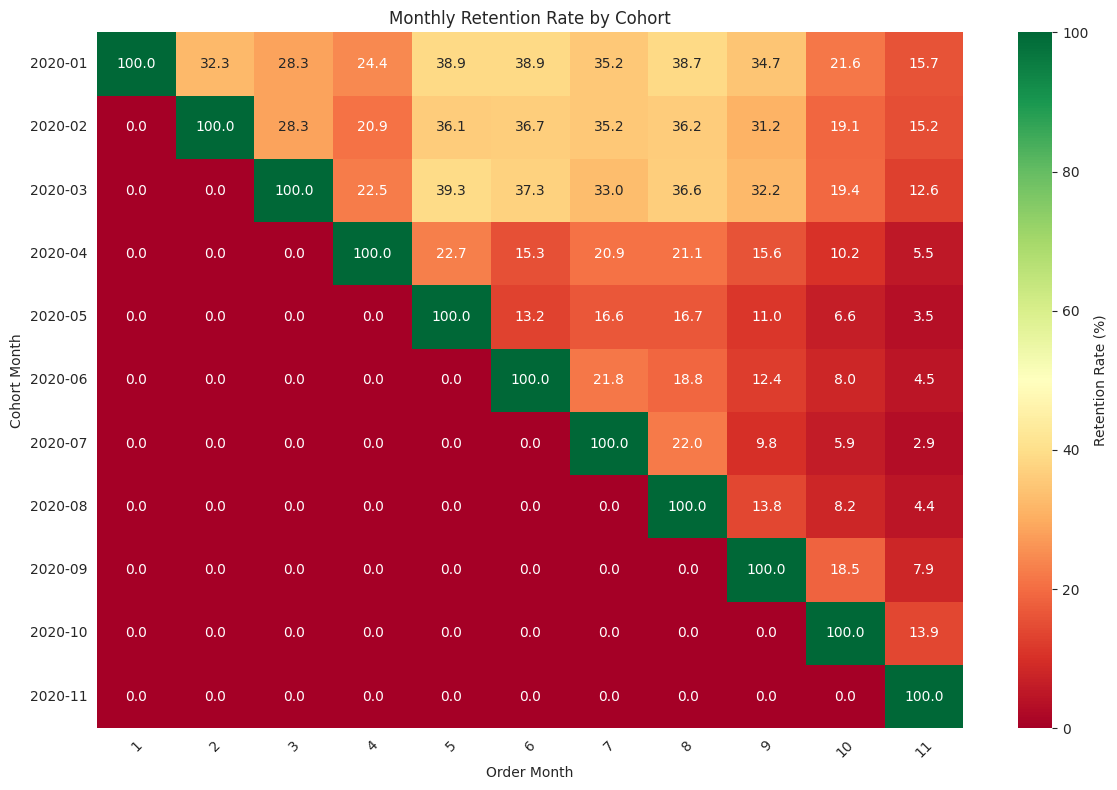


월별 이탈률 코호트 분석 결과:
   cohort_month  order_month  Total_users  Cohort_Size  Retention_Rate
0       2020-01            1         1431         1431      100.000000
1       2020-01            2          462         1431       32.285115
2       2020-01            3          405         1431       28.301887
3       2020-01            4          349         1431       24.388539
4       2020-01            5          557         1431       38.923829
..          ...          ...          ...          ...             ...
61      2020-09           10         1580         8552       18.475210
62      2020-09           11          675         8552        7.892891
63      2020-10           10         5771         5771      100.000000
64      2020-10           11          803         5771       13.914400
65      2020-11           11         2959         2959      100.000000

[66 rows x 5 columns]


In [ ]:
# 주문 주기
df['cohort_month'] = df['Join_Date'].dt.to_period('M')
df['order_month'] = df['month']

# 월별 구매자 수
monthly_cohort = df.groupby(['cohort_month', 'order_month'])['user_id'].nunique().reset_index()
monthly_cohort = monthly_cohort.rename(columns={'user_id' : 'Total_users'})

# 월별 코호트 전체 유저 (첫달 가입자수가 기준)
cohort_sizes = monthly_cohort.groupby('cohort_month')['Total_users'].first().reset_index()
cohort_sizes = cohort_sizes.rename(columns={'Total_users': 'Cohort_Size'})

# 월별 구매자수와 가입한 전체 인원 병합
monthly_cohort = pd.merge(monthly_cohort, cohort_sizes, on='cohort_month')

# 이탈률 계산 (Cohort_Size가 아닌 Total_users를 기준으로)
monthly_cohort['Retention_Rate'] = (monthly_cohort['Total_users'] / monthly_cohort['Cohort_Size']) * 100

# 시각화
plt.figure(figsize=(12, 8))
heatmap_data = monthly_cohort.pivot_table(index='cohort_month', columns='order_month', values='Retention_Rate', fill_value=0)
sns.heatmap(heatmap_data, annot=True, fmt='.1f', cmap='RdYlGn', cbar_kws={'label': 'Retention Rate (%)'})
plt.title('Monthly Retention Rate by Cohort')
plt.xlabel('Order Month')
plt.ylabel('Cohort Month')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 결과 출력
print("\n월별 이탈률 코호트 분석 결과:")
print(monthly_cohort[['cohort_month', 'order_month', 'Total_users', 'Cohort_Size', 'Retention_Rate']])

- 2020년 5, 6, 7, 8, 9월에 1~3월 가입한 유저들의 리텐션이 상승한 것을 파악
- 해당월에 어떤 이벤트나 프로모션이 있었는지 확인 필요
- 4~9월애 가입한 유저들의 리텐션이 빠르게 낮아지고 유지가 어려워 보임

-> 리텐션을 상승 시킬 수 있는 요인에 대한 인사이트를 얻을 수 있음

2. 타켓 고객(Loyal Customers와 High-Value Customers)의 리텐션 분석

In [ ]:
#Loyal Customers와 High-Value Customers에 대한 데이터
Target_df= df[(df['Customer_Segment'] == 'Loyal Customers') | (df['Customer_Segment'] == 'High-Value Customers')]

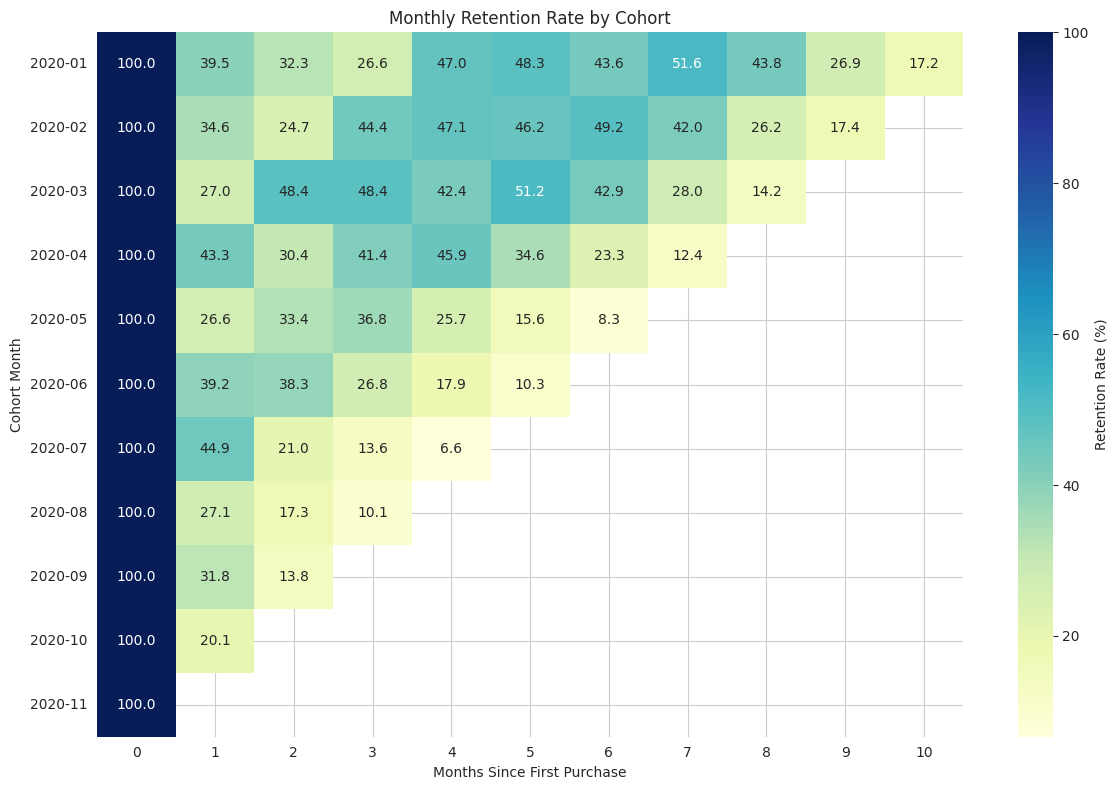


월별 리텐션 코호트 분석 결과:
   cohort_month  month_diff  Total_users  Cohort_Size  Retention_Rate
0       2020-01           0          721          721      100.000000
1       2020-01           1          285          721       39.528433
2       2020-01           2          233          721       32.316227
3       2020-01           3          192          721       26.629681
4       2020-01           4          339          721       47.018031
..          ...         ...          ...          ...             ...
61      2020-09           1         1080         3398       31.783402
62      2020-09           2          469         3398       13.802237
63      2020-10           0         2154         2154      100.000000
64      2020-10           1          434         2154       20.148561
65      2020-11           0          905          905      100.000000

[66 rows x 5 columns]


In [ ]:
# 월별 구매자 수
monthly_cohort_1 = Target_df.groupby(['cohort_month', 'month_diff'])['user_id'].nunique().reset_index()
monthly_cohort_1 = monthly_cohort_1.rename(columns={'user_id': 'Total_users'})

# 월별 코호트 전체 유저 (첫달 가입자수가 기준)
cohort_sizes_1 = monthly_cohort_1[monthly_cohort_1['month_diff'] == 0].set_index('cohort_month')['Total_users']
cohort_sizes_1 = cohort_sizes_1.rename('Cohort_Size')

# 월별 구매자수와 가입한 전체 인원 병합
monthly_cohort_1 = monthly_cohort_1.set_index('cohort_month').join(cohort_sizes_1)

# 리텐션 비율 계산
monthly_cohort_1['Retention_Rate'] = (monthly_cohort_1['Total_users'] / monthly_cohort_1['Cohort_Size']) * 100

# 시각화
plt.figure(figsize=(12, 8))
retention_matrix = monthly_cohort_1.pivot_table(values='Retention_Rate', index='cohort_month', columns='month_diff')
sns.heatmap(retention_matrix, annot=True, fmt='.1f', cmap='YlGnBu', cbar_kws={'label': 'Retention Rate (%)'})
plt.title('Monthly Retention Rate by Cohort')
plt.xlabel('Months Since First Purchase')
plt.ylabel('Cohort Month')
plt.tight_layout()
plt.show()

# 결과 출력
print("\n월별 리텐션 코호트 분석 결과:")
print(monthly_cohort_1.reset_index()[['cohort_month', 'month_diff', 'Total_users', 'Cohort_Size', 'Retention_Rate']])

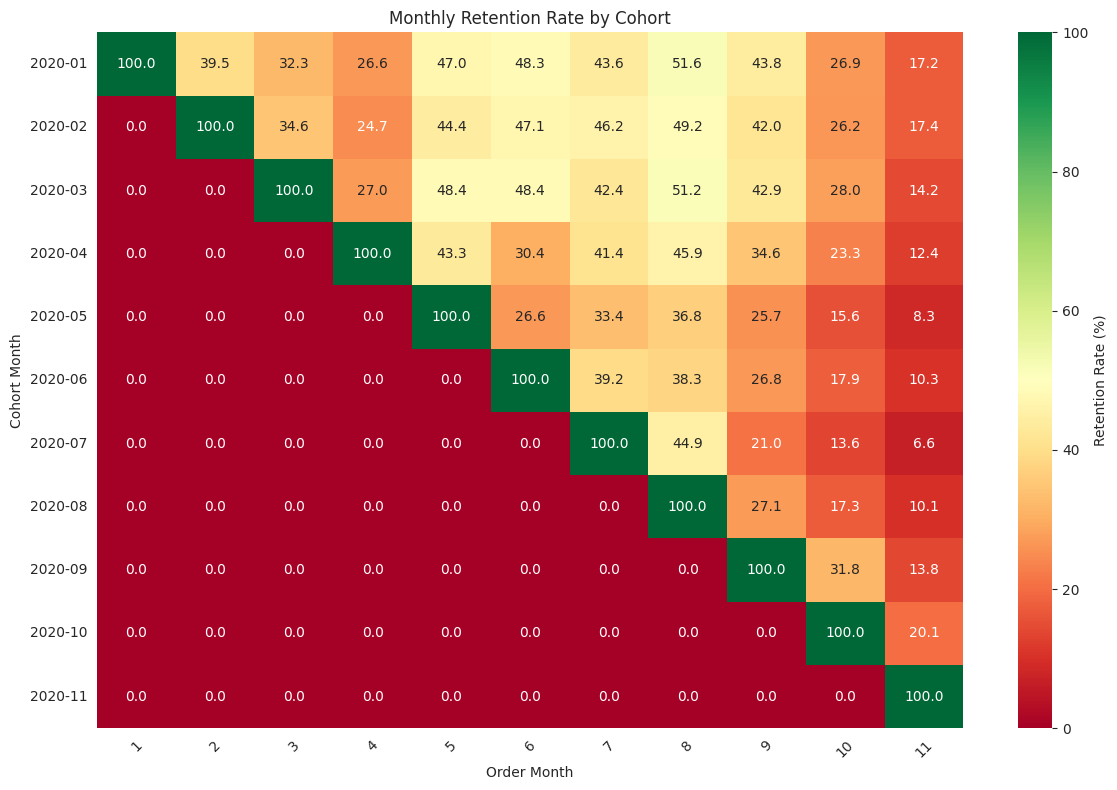


월별 이탈률 코호트 분석 결과:
   cohort_month  order_month  Total_users  Cohort_Size  Retention_Rate
0       2020-01            1          721          721      100.000000
1       2020-01            2          285          721       39.528433
2       2020-01            3          233          721       32.316227
3       2020-01            4          192          721       26.629681
4       2020-01            5          339          721       47.018031
..          ...          ...          ...          ...             ...
61      2020-09           10         1080         3398       31.783402
62      2020-09           11          469         3398       13.802237
63      2020-10           10         2154         2154      100.000000
64      2020-10           11          434         2154       20.148561
65      2020-11           11          905          905      100.000000

[66 rows x 5 columns]


In [ ]:
# 월별 구매자 수
monthly_cohort_1 = Target_df.groupby(['cohort_month', 'order_month'])['user_id'].nunique().reset_index()
monthly_cohort_1 = monthly_cohort_1.rename(columns={'user_id' : 'Total_users'})

# 월별 코호트 전체 유저 (첫달 가입자수가 기준)
cohort_sizes_1 = monthly_cohort_1.groupby('cohort_month')['Total_users'].first().reset_index()
cohort_sizes_1 = cohort_sizes_1.rename(columns={'Total_users': 'Cohort_Size'})

# 월별 구매자수와 가입한 전체 인원 병합
monthly_cohort_1 = pd.merge(monthly_cohort_1, cohort_sizes_1, on='cohort_month')

# 이탈률 계산 (Cohort_Size가 아닌 Total_users를 기준으로)
monthly_cohort_1['Retention_Rate'] = (monthly_cohort_1['Total_users'] / monthly_cohort_1['Cohort_Size']) * 100

# 시각화
plt.figure(figsize=(12, 8))
heatmap_data = monthly_cohort_1.pivot_table(index='cohort_month', columns='order_month', values='Retention_Rate', fill_value=0)
sns.heatmap(heatmap_data, annot=True, fmt='.1f', cmap='RdYlGn', cbar_kws={'label': 'Retention Rate (%)'})
plt.title('Monthly Retention Rate by Cohort')
plt.xlabel('Order Month')
plt.ylabel('Cohort Month')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 결과 출력
print("\n월별 이탈률 코호트 분석 결과:")
print(monthly_cohort_1[['cohort_month', 'order_month', 'Total_users', 'Cohort_Size', 'Retention_Rate']])

- 전체 유저에 대한 코호트 분석과 비슷하게 타겟 고객에 대한 코호트 분석을 실시한 결과, 비슷한 경향성을 보이는 것을 확인할 수 있음
- 1~3월 가입한 유저들의 리텐션이 2020년 5, 6, 7, 8, 9월에  상승 및 유지되고 있는 것을 파악할 수 있음
- 타겟 고객의 리텐션이 전체 유저를 대상으로 리텐션을 구했을때 보다 높다는 것을 확인할 수 있음
- 타겟 고객을 대상으로 2020년 5, 6, 7, 8, 9에 리텐션을 상승할 만한 요소가 무엇이었는지에 대한 분석의 필요성을 확인

### **가설 증명 및 타켓 고객(Loyal Customers와 High-Value Customers)에 대한 추가적인 분석(EDA)**

---



가격, 카테고리, 제품, 브랜드의 변수에 대해 타겟 고객들은 어떠한 경향성을 가지고 있는지 파악

가격과 리텐션의 상관관계 분석

Target_df에 Retention Rate 추가

In [ ]:
Target_df = pd.merge(Target_df, monthly_cohort_1[['cohort_month', 'order_month', 'Retention_Rate']],
                     on=['cohort_month', 'order_month'], how='left')

In [ ]:
correlation_price_retention = Target_df[['Retention_Rate', 'price']].corr().iloc[0, 1]
print(f"가격과 리텐션 비율의 상관관계: {correlation_price_retention:.4f}")

가격과 리텐션 비율의 상관관계: 0.1304


In [ ]:
Target_df.head()

,event_time,order_id,product_id,category_id,category_code,brand,price,user_id,category,product,...,hour,Customer_Segment_y,month,Customer_Segment,Join_Date,cohort_month,join_month,order_month,month_diff,Retention_Rate
0,2020-04-24 14:37:43+00:00,2294444024058086220,2273948319057183658,2.268105e+18,electronics.audio.headphone,huawei,77.52,1.515916e+18,electronics,headphone,...,14,Loyal Customers,4,Loyal Customers,2020-04-24 14:37:43+00:00,2020-04,4,4,0,100.000000
1,2020-04-26 09:33:47+00:00,2295740594749702229,1515966223509104892,2.268105e+18,electronics.smartphone,apple,1387.01,1.515916e+18,electronics,smartphone,...,9,Loyal Customers,4,Loyal Customers,2020-04-26 09:33:47+00:00,2020-04,4,4,0,100.000000
2,2020-04-28 09:01:47+00:00,2297174044555871159,2273948222957290212,2.268105e+18,computers.peripherals.monitor,samsung,254.61,1.515916e+18,computers,monitor,...,9,High-Value Customers,4,High-Value Customers,2020-04-28 09:01:47+00:00,2020-04,4,4,0,100.000000
3,2020-04-29 06:21:53+00:00,2297818341995184662,1515966223509382310,2.268105e+18,appliances.kitchen.kettle,tefal,7.85,1.515916e+18,appliances,kettle,...,6,High-Value Customers,4,High-Value Customers,2020-04-29 06:21:53+00:00,2020-04,4,4,0,100.000000
4,2020-04-29 10:38:40+00:00,2297947579247231353,1515966223509881617,2.268105e+18,computers.components.memory,kingston,49.98,1.515916e+18,computers,memory,...,10,Loyal Customers,4,Loyal Customers,2020-03-09 12:16:33+00:00,2020-03,3,4,1,27.002967


- 이를통해 가격과 리텐션은 높은 연관성이 없는 것을 확인

타겟 고객이 구매하는 카테고리 중 판매 액이 높은 카테고리 TOP 10

타겟고객이 많이 구매한 카테고리 TOP 10

<ipython-input-45-8d421d07d8ad>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='category', y='price', data=Selling_Amount_10_Categories, palette='viridis', ax=axs[0])
<ipython-input-45-8d421d07d8ad>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='category', y='order_id', data=Selling_Number_10_Brands, palette='viridis', ax=axs[1])


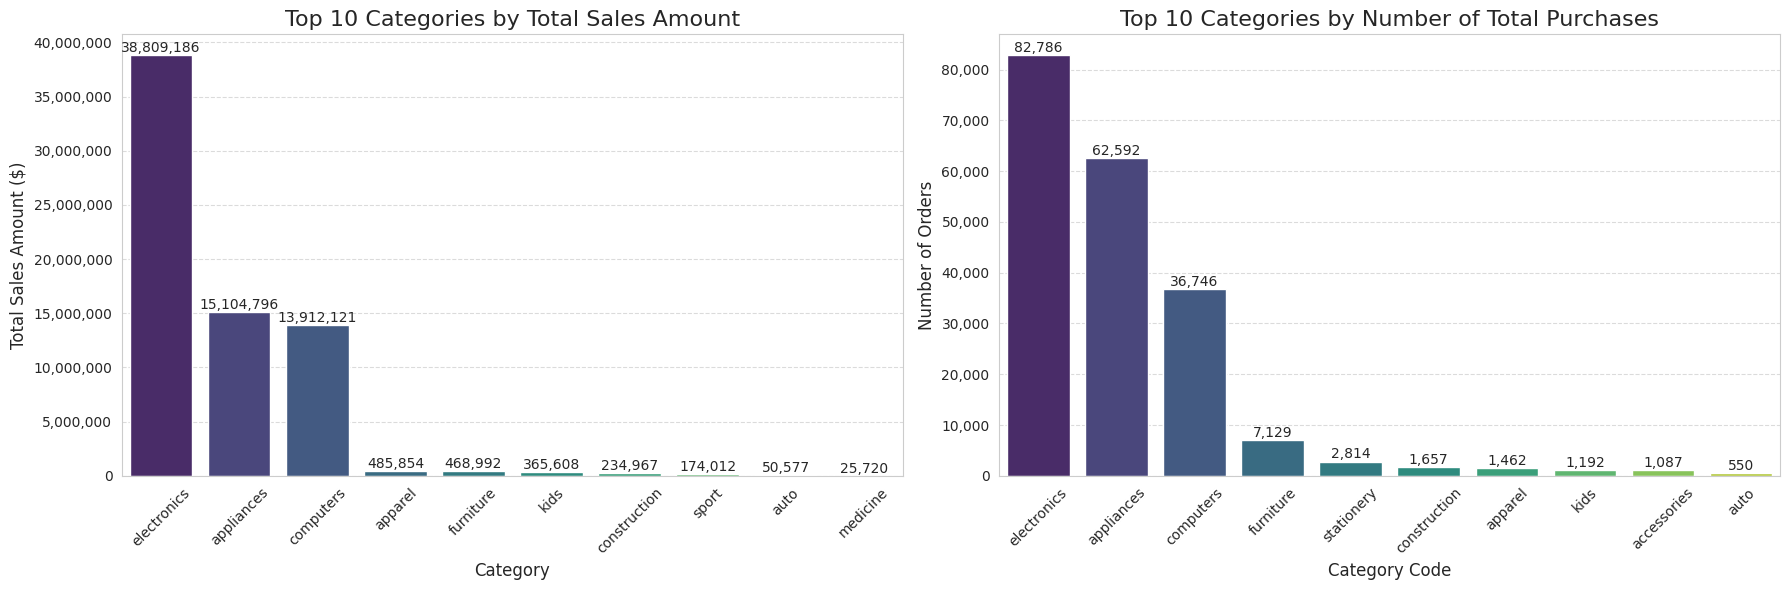

In [ ]:
# 판매 금액 상위 10개 카테고리
Selling_Amount_10_Categories = Target_df.groupby('category')['price'].sum().reset_index().sort_values('price', ascending=False).head(10)

# 주문 수 상위 10개 브랜드
Selling_Number_10_Brands = Target_df.groupby('category')['order_id'].count().reset_index().sort_values('order_id', ascending=False).head(10)

# 서브플롯 설정
fig, axs = plt.subplots(1, 2, figsize=(18, 6))

# 첫 번째 그래프: Top Categories by Total Sales Amount
sns.barplot(x='category', y='price', data=Selling_Amount_10_Categories, palette='viridis', ax=axs[0])
axs[0].set_title('Top 10 Categories by Total Sales Amount', fontsize=16)
axs[0].set_xlabel('Category', fontsize=12)
axs[0].set_ylabel('Total Sales Amount ($)', fontsize=12)
axs[0].tick_params(axis='x', rotation=45)

# y축 포맷 설정
axs[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))

# 막대 위에 값 표시
for i, v in enumerate(Selling_Amount_10_Categories['price']):
    axs[0].text(i, v + 2000, f'{v:,.0f}', ha='center', va='bottom')

axs[0].grid(axis='y', linestyle='--', alpha=0.7)

# 두 번째 그래프: Top Categories by Number of Orders
sns.barplot(x='category', y='order_id', data=Selling_Number_10_Brands, palette='viridis', ax=axs[1])
axs[1].set_title('Top 10 Categories by Number of Total Purchases', fontsize=16)
axs[1].set_xlabel('Category Code', fontsize=12)
axs[1].set_ylabel('Number of Orders', fontsize=12)
axs[1].tick_params(axis='x', rotation=45)

# y축 포맷 설정
axs[1].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))

# 막대 위에 값 표시
for i, v in enumerate(Selling_Number_10_Brands['order_id']):
    axs[1].text(i, v + 20, f'{v:,}', ha='center', va='bottom')

axs[1].grid(axis='y', linestyle='--', alpha=0.7)

# 레이아웃 조정 및 출력
plt.tight_layout()
plt.show()



- 타겟 고객들이 구매하는 카테고리 중 electronics, appliances, computers를 통한 판매액이 높은 것을 확인
- 타겟 고객들이 구매하는 카테고리 중 electronics, appliances, computers를 많이 구매하는 것을 확인

electronics를 구매하는 고객들과 아닌 고객들의 리텐션 평균

In [ ]:
# "electronics" 카테고리 필터링
category_analysis = Target_df[Target_df['category'] == 'electronics']
non_category_analysis = Target_df[Target_df['category'] != 'electronics']

print(f"Average Retention Rate for Electronics을 구매한 타겟 고객: {category_analysis['Retention_Rate'].mean():.2f}%")
print(f"Average Retention Rate for Electronics을 구매하지 않은 타겟 고객: {non_category_analysis['Retention_Rate'].mean():.2f}%")

Average Retention Rate for Electronics을 구매한 타겟 고객: 71.71%
Average Retention Rate for Electronics을 구매하지 않은 타겟 고객: 65.76%


- 두 그룹간의 평균 리텐션 차이가 많이 나지 않다는 것을 확인

타겟 고객이 구매하는 브랜드 중 판매 액이 높은 브랜드 TOP 10

<ipython-input-47-c8aa62b8f288>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='brand', y='price', data=Selling_Amount_10_Brands, palette='viridis', ax=axs[0])
<ipython-input-47-c8aa62b8f288>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='brand', y='order_id', data=Selling_Number_10_Brands, palette='viridis', ax=axs[1])


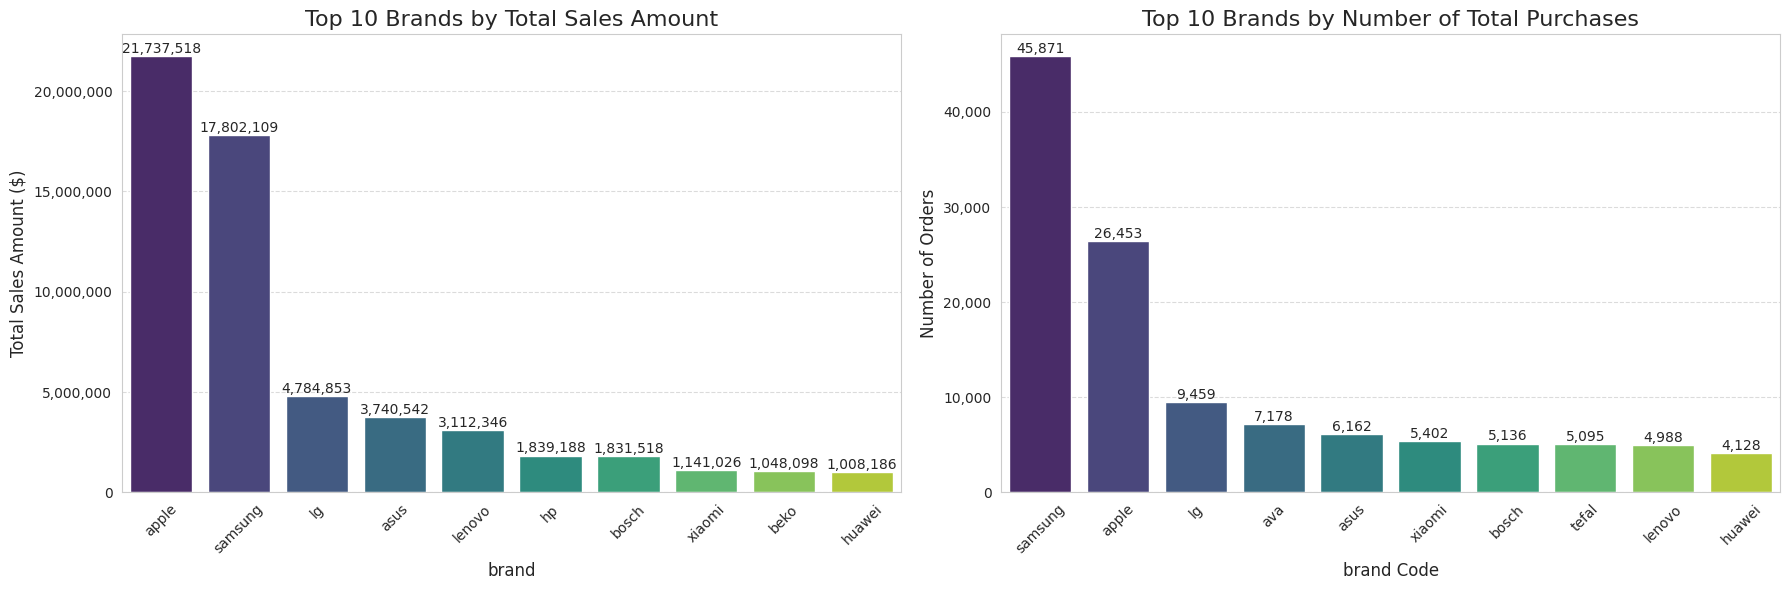

In [ ]:
# 판매 금액 상위 10개 카테고리
Selling_Amount_10_Brands = Target_df.groupby('brand')['price'].sum().reset_index().sort_values('price', ascending=False).head(10)

# 주문 수 상위 10개 브랜드
Selling_Number_10_Brands = Target_df.groupby('brand')['order_id'].count().reset_index().sort_values('order_id', ascending=False).head(10)

# 서브플롯 설정
fig, axs = plt.subplots(1, 2, figsize=(18, 6))

# 첫 번째 그래프: Top Brands by Total Sales Amount
sns.barplot(x='brand', y='price', data=Selling_Amount_10_Brands, palette='viridis', ax=axs[0])
axs[0].set_title('Top 10 Brands by Total Sales Amount', fontsize=16)
axs[0].set_xlabel('brand', fontsize=12)
axs[0].set_ylabel('Total Sales Amount ($)', fontsize=12)
axs[0].tick_params(axis='x', rotation=45)

# y축 포맷 설정
axs[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))

# 막대 위에 값 표시
for i, v in enumerate(Selling_Amount_10_Brands['price']):
    axs[0].text(i, v + 2000, f'{v:,.0f}', ha='center', va='bottom')

axs[0].grid(axis='y', linestyle='--', alpha=0.7)

# 두 번째 그래프: Top Brands by Number of Orders
sns.barplot(x='brand', y='order_id', data=Selling_Number_10_Brands, palette='viridis', ax=axs[1])
axs[1].set_title('Top 10 Brands by Number of Total Purchases', fontsize=16)
axs[1].set_xlabel('brand Code', fontsize=12)
axs[1].set_ylabel('Number of Orders', fontsize=12)
axs[1].tick_params(axis='x', rotation=45)

# y축 포맷 설정
axs[1].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))

# 막대 위에 값 표시
for i, v in enumerate(Selling_Number_10_Brands['order_id']):
    axs[1].text(i, v + 20, f'{v:,}', ha='center', va='bottom')

axs[1].grid(axis='y', linestyle='--', alpha=0.7)

# 레이아웃 조정 및 출력
plt.tight_layout()
plt.show()



In [ ]:
# "apple" 카테고리 필터링
brand_analysis = Target_df[Target_df['brand'].isin(['apple', 'samsung'])]
non_brand_analysis = Target_df[(Target_df['brand'] != 'apple') & (Target_df['brand'] != 'samsung')]

print(f"Average Retention Rate for apple과 samsung 구매한 타겟 고객: {brand_analysis['Retention_Rate'].mean():.2f}%")
print(f"Average Retention Rate for apple과 samsung 구매하지 않은 타겟 고객: {non_brand_analysis['Retention_Rate'].mean():.2f}%")

Average Retention Rate for apple과 samsung 구매한 타겟 고객: 72.96%
Average Retention Rate for apple과 samsung 구매하지 않은 타겟 고객: 65.54%


- 대략 7% 차이가 나는 것을 확인
- 두 그룹간의 리텐션 차이가 유의미한지 확인하기 위해 T-test를 진행

In [ ]:
from scipy import stats

t_statistic, p_value = stats.ttest_ind(brand_analysis['Retention_Rate'], non_brand_analysis['Retention_Rate'], alternative='less')
print(t_statistic, p_value)

45.95608001925607 1.0


- 귀무가설(H0): 두 그룹의 리탠션율은 동일하다.
- 대립가설(H1): 두 그룹의 리텐션율은 동일하지 않다.

-> P-value가 0.05 보다 큼으로 귀무가설을 기각하지 않음

>즉, 두 그룹의 리텐션에 대한 차이가 유의미하지 않다는 것을 확인


<ipython-input-50-ae0296921bd4>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='product', y='price', data=Selling_Amount_10_Products, palette='viridis', ax=axs[0])
<ipython-input-50-ae0296921bd4>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='product', y='order_id', data=Selling_Number_10_Brands, palette='viridis', ax=axs[1])


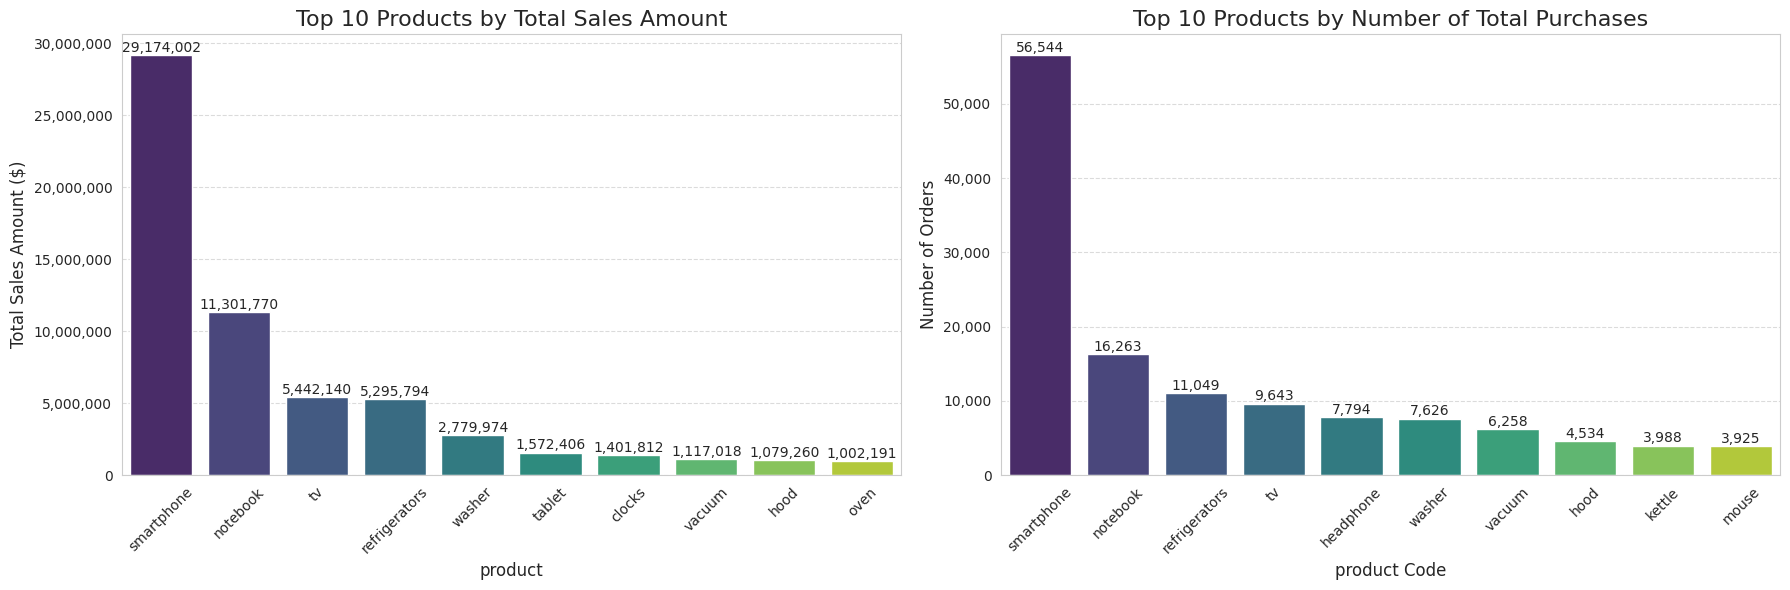

In [ ]:
# 판매 금액 상위 10개 카테고리
Selling_Amount_10_Products = Target_df.groupby('product')['price'].sum().reset_index().sort_values('price', ascending=False).head(10)

# 주문 수 상위 10개 브랜드
Selling_Number_10_Brands = Target_df.groupby('product')['order_id'].count().reset_index().sort_values('order_id', ascending=False).head(10)

# 서브플롯 설정
fig, axs = plt.subplots(1, 2, figsize=(18, 6))

# 첫 번째 그래프: Top Products by Total Sales Amount
sns.barplot(x='product', y='price', data=Selling_Amount_10_Products, palette='viridis', ax=axs[0])
axs[0].set_title('Top 10 Products by Total Sales Amount', fontsize=16)
axs[0].set_xlabel('product', fontsize=12)
axs[0].set_ylabel('Total Sales Amount ($)', fontsize=12)
axs[0].tick_params(axis='x', rotation=45)

# y축 포맷 설정
axs[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))

# 막대 위에 값 표시
for i, v in enumerate(Selling_Amount_10_Products['price']):
    axs[0].text(i, v + 2000, f'{v:,.0f}', ha='center', va='bottom')

axs[0].grid(axis='y', linestyle='--', alpha=0.7)

# 두 번째 그래프: Top Products by Number of Orders
sns.barplot(x='product', y='order_id', data=Selling_Number_10_Brands, palette='viridis', ax=axs[1])
axs[1].set_title('Top 10 Products by Number of Total Purchases', fontsize=16)
axs[1].set_xlabel('product Code', fontsize=12)
axs[1].set_ylabel('Number of Orders', fontsize=12)
axs[1].tick_params(axis='x', rotation=45)

# y축 포맷 설정
axs[1].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))

# 막대 위에 값 표시
for i, v in enumerate(Selling_Number_10_Brands['order_id']):
    axs[1].text(i, v + 20, f'{v:,}', ha='center', va='bottom')

axs[1].grid(axis='y', linestyle='--', alpha=0.7)

# 레이아웃 조정 및 출력
plt.tight_layout()
plt.show()

In [ ]:
# "smartphone" 카테고리 필터링
product_analysis = Target_df[Target_df['product'] == 'smartphone']
non_product_analysis = Target_df[Target_df['product'] != 'smartphone']

print(f"Average Retention Rate for smartphone를 구매한 타겟 고객: {product_analysis['Retention_Rate'].mean():.2f}%")
print(f"Average Retention Rate for smartphone를 구매하지 않은 타겟 고객: {non_product_analysis['Retention_Rate'].mean():.2f}%")

Average Retention Rate for smartphone를 구매한 타겟 고객: 74.11%
Average Retention Rate for smartphone를 구매하지 않은 타겟 고객: 65.91%


In [ ]:
total_sales = Target_df.groupby('product')['price'].sum().reset_index()

# 전체 판매 금액 계산
total_amount = total_sales['price'].sum()

# 판매 금액 기준 내림차순 정렬 및 상위 10개 제품 선택
top_10_products = total_sales.sort_values('price', ascending=False).head(10)

# 상위 10개 제품의 판매 비율 계산
top_10_products['percentage'] = (top_10_products['price'] / total_amount) * 100

# 결과 출력
print(top_10_products[['product', 'price', 'percentage']])

           product        price  percentage
88      smartphone  29174002.26   41.861564
66        notebook  11301769.82   16.216827
109             tv   5442140.49    7.808888
77   refrigerators   5295793.51    7.598896
115         washer   2779974.25    3.988965
99          tablet   1572405.72    2.256234
21          clocks   1401811.93    2.011450
111         vacuum   1117018.01    1.602801
48            hood   1079260.28    1.548623
67            oven   1002191.44    1.438037


- 대략 10% 차이가 나는 것을 확인
- 특히 Smartphone은 전체 판매 금액의 16% 차지할 정도로 많은 비중을 차지

- 두 그룹간의 리텐션 차이가 유의미한지 확인하기 위해 T-test를 진행

In [ ]:
from scipy import stats

t_statistic, p_value = stats.ttest_ind(product_analysis['Retention_Rate'], non_product_analysis['Retention_Rate'], alternative='less')
print(t_statistic, p_value)

47.60520961624596 1.0


- 귀무가설(H0): 두 그룹의 리탠션율은 동일하다.
- 대립가설(H1): 두 그룹의 리텐션율은 동일하지 않다.

-> P-value가 0.05 보다 큼으로 귀무가설을 기각하지 않음

>즉, 두 그룹의 리텐션에 대한 차이가 유의미하지 않다는 것을 확인

### **결론**

---



**RFM 분석**

- RFM을 기준으로 고객 세그먼트를 나누고, 각 집단간의 RFM에 대한 평균 값의 통계적 유의성을 확인

> 단, recency값의 데이터가 표준 분포를 따르지 않아 비모수 검정법(Kruskal-Wallis H-test)을 통해 값을 확인.


- RFM EDA 결과, 타겟 고객에 대해 21시부터 3시까지의 판매가 가장 많은 것을 확인
- 연말에 가까울수록 타겟 고객의 구매 빈도가 늘어나는 것을 확인.
- 특히, VIP 고객의 경우, 10월부터 극격히 구매가 늘어난다는 점에 주목할 필요가 있음
- 6월 이후로 충성고객에 대한 판매액이 급격하게 늘어나고 있는 것을 확인

**Cohort 분석**

- 전체 유저의 리텐션에 대한 코호트 분석 결과, 5,6,7,8,9 월 달에 대한 리텐션(재구매율)이 높아지는 것을 확인
- 타켓 고객(Loyal Customers와 High-Value Customers)또한 리텐션에 대한 코호트 분석 결과, 5,6,7,8,9 월 달에 대한 리텐션(재구매율)이 높아지는 것을 확인
- 타겟 고객에 대한 추가적인 분석을 통해 2020년 5, 6, 7, 8, 9에 리텐션을 상승할 만한 요소가 무엇이었는지에 대한 분석의 필요성을 확인
- 연말에 가까울수록 고객들의 구매 빈도가 늘어나는것과 달리 리텐션은 상승하지 않는 것이 인상적

> -> 구매량과 리텐션은 연관성이 없다는 것을 간접적으로 확인

=> 전자 기기를 파는 플랫폼 비즈니스에서 큰 매출을 만들어내는 고객들을 집중 관리 및 증가시키는 것이 소액을 자주 구매하는 고객 보다 중요하다고 판단.
> * 특히 VIP를 제외한 High-Value, Loyal Customers의 구매액이 다른 세그먼트 고객들 보다 압도적으로 높다는 점을 고려

> * 이에 해당 고객들의 리텐션을 높여 재구매를 유도하는 것이 매출을 꾸준히 향상시킬 수 있을 것이라는 가설을 세움

**가설 증명 및 타켓 고객(Loyal Customers와 High-Value Customers)에 대한 추가적인 분석(EDA)**

가격과 리텐션의 상관관계 분석을 통해, 두 변수가 높은 상관관계를 가지고 있지 않다는 것을 확인
> -> 이를통해 유저의 리텐션을 높여 재구매를 유도하는 것이 매출을 꾸준히 향상시킬 수 있을 것이라는 가설을 증명하기 어렵다는 결론을 지을 수 있었음

리텐션을 상승시킬 수 있는 요인(브랜드, 카테고리, 제품)에 대한 추가적인 분석을 통해,
1. 타겟 고객은 전자, 가전 제품를 주로 구매
2. 애플과 삼성 브랜드를 선호
3. 전자제품은 스마트폰과 노트북, 가전은 냉장고를 많이 구매한다는 것을 확인
> 특히, 스마트폰은 41% 매출 비중을 차지할 정도로 높은 판매량을 기록

이러한 요소가 타겟 고객의 리텐션을 상승시킬 수 있는지에 대한 통계적 유의성을 확인하기 위해,

해당 브랜드, 카테고리, 제품을 구매한 고객과 아닌 고객들의 리텐션에 대한 t-test를 진행

하지만, 통계적 유의성을 확인하기 어려운 것을 확인



**종합 인사이트**

- 5, 6, 7, 8, 9월에 타겟고객들의 리텐션이 상승한 원인이 무엇인지 확인 필요 (ex. 프로모션, 이벤트, 시즈널리티)
- 전자제품 시장 특성상, 연말에 판매량이 증가하며 타겟 고객 또한 이와 같은 경향성을 가지고 있다는 점을 활용할 필요가 있음
- 고객들의 선호 카테고리, 브랜드, 제품을 인지하고 영업/마케팅에 반영한다면 긍정적 피드백으로 돌아올 수 있다고 생각.
> (하지만, 고객 선호 중심 전략이 곧 리텐션과 매출 증가로 이어진다는 것을 의미하지 않음)
- 고객들의 리텐션을 증가시킬 수 있는 요인이 무엇인지에 대한 분석이 필요하며, 이를 위한 데이터 확보가 필요함